In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 20  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    for layer in range(image.shape[2]):
        image_=image[:,:,layer]
        clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
        cl1 = clahe.apply(image_)
        image[:,:,layer]=cl1
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



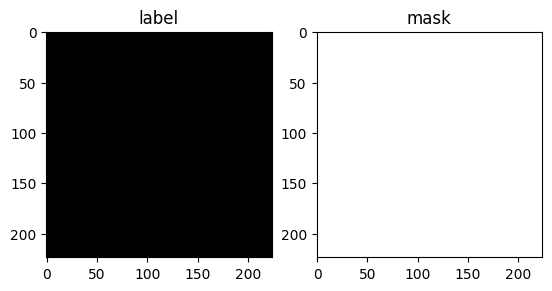

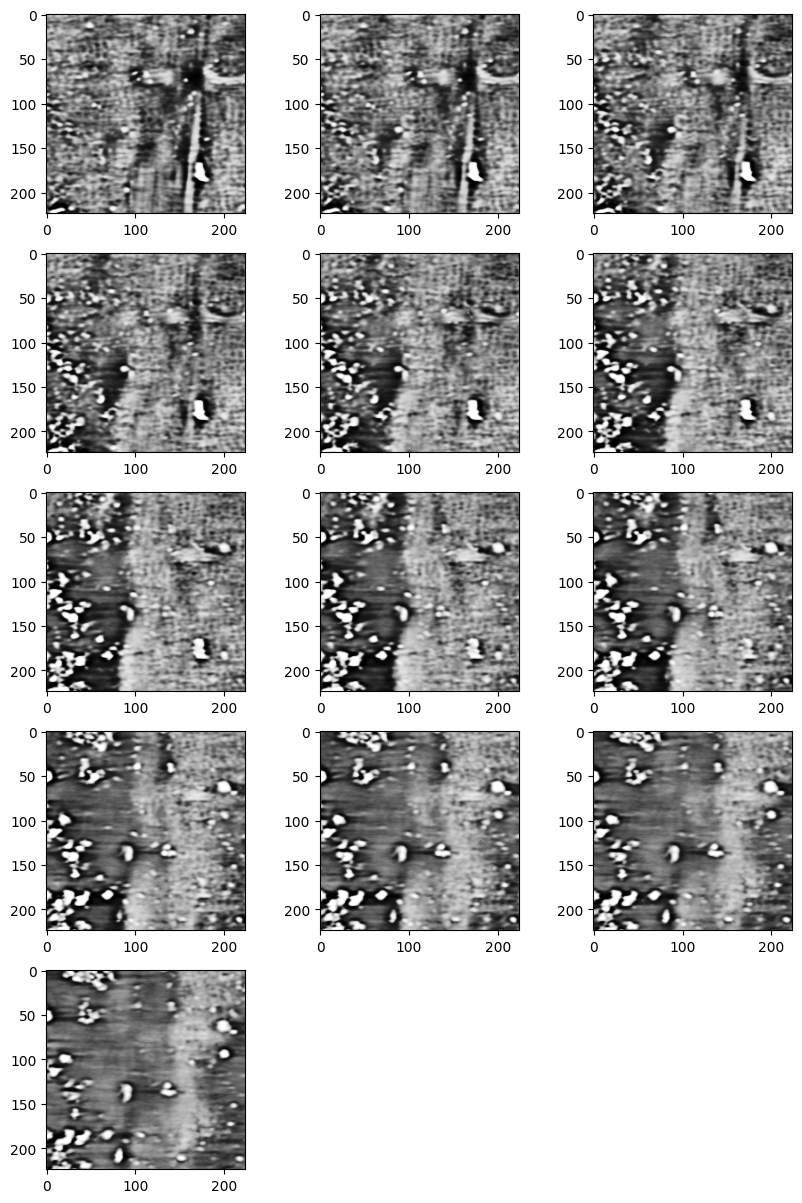

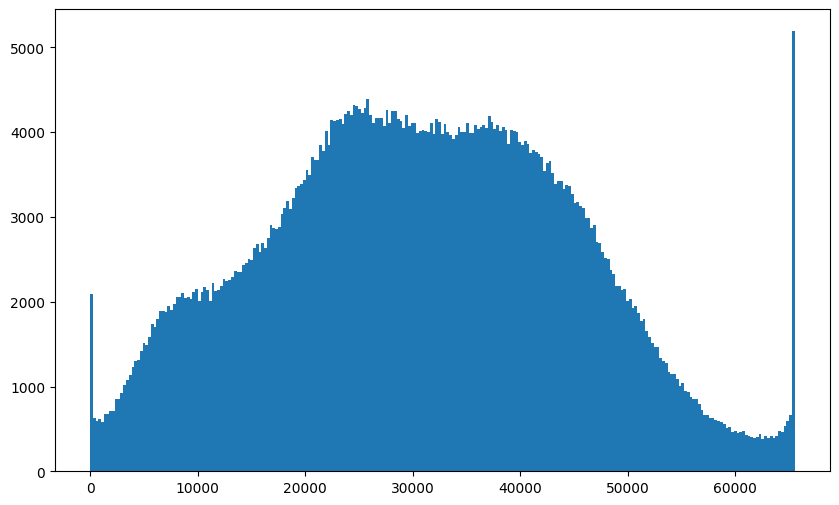

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


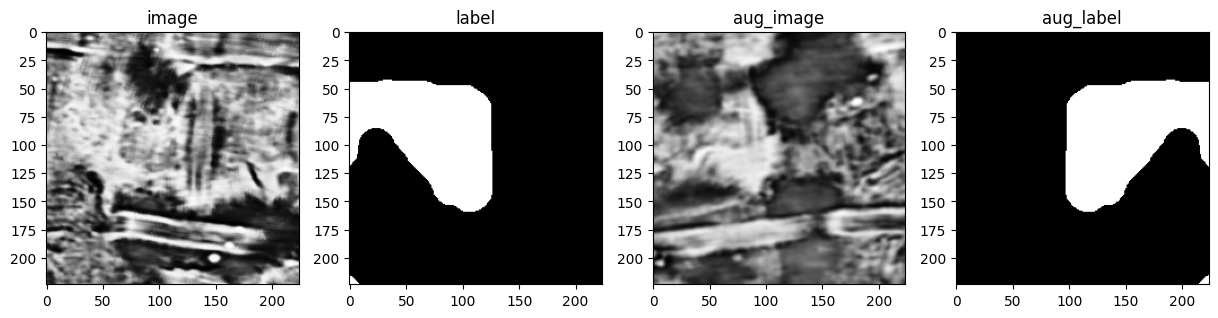

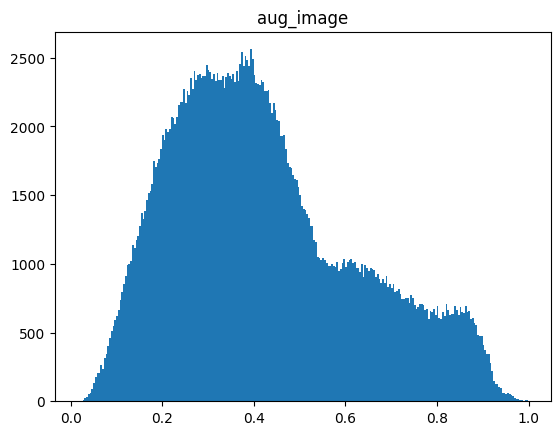

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 21.99it/s]


fbeta: 0.3265
Epoch 1 - avg_train_loss: 1.3967  avg_val_loss: 1.1311  avgScore: 0.3265  time: 77s
Epoch 1 - Save Best Loss: 1.1311  Best Score: 0.3265 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.21it/s]


fbeta: 0.3473
Epoch 2 - avg_train_loss: 1.1943  avg_val_loss: 1.0855  avgScore: 0.3473  time: 71s
Epoch 2 - Save Best Loss: 1.0855  Best Score: 0.3473 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.47it/s]


fbeta: 0.3005
Epoch 3 - avg_train_loss: 1.0217  avg_val_loss: 0.9899  avgScore: 0.3005  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.32it/s]


fbeta: 0.3831
Epoch 4 - avg_train_loss: 0.9301  avg_val_loss: 0.9271  avgScore: 0.3831  time: 70s
Epoch 4 - Save Best Loss: 0.9271  Best Score: 0.3831 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.47it/s]


fbeta: 0.4334
Epoch 5 - avg_train_loss: 0.8788  avg_val_loss: 0.8819  avgScore: 0.4334  time: 70s
Epoch 5 - Save Best Loss: 0.8819  Best Score: 0.4334 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.47it/s]


fbeta: 0.4587
Epoch 6 - avg_train_loss: 0.8273  avg_val_loss: 0.8981  avgScore: 0.4587  time: 70s
Epoch 6 - Save Best Loss: 0.8981  Best Score: 0.4587 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.35it/s]


fbeta: 0.4455
Epoch 7 - avg_train_loss: 0.8285  avg_val_loss: 0.8863  avgScore: 0.4455  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.37it/s]


fbeta: 0.4344
Epoch 8 - avg_train_loss: 0.8016  avg_val_loss: 0.9177  avgScore: 0.4344  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.45it/s]


fbeta: 0.4560
Epoch 9 - avg_train_loss: 0.7639  avg_val_loss: 0.8841  avgScore: 0.4560  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.55it/s]


fbeta: 0.4599
Epoch 10 - avg_train_loss: 0.7416  avg_val_loss: 0.9025  avgScore: 0.4599  time: 69s
Epoch 10 - Save Best Loss: 0.9025  Best Score: 0.4599 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.54it/s]


fbeta: 0.4408
Epoch 11 - avg_train_loss: 0.7476  avg_val_loss: 0.9058  avgScore: 0.4408  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.41it/s]


fbeta: 0.4899
Epoch 12 - avg_train_loss: 0.7164  avg_val_loss: 0.8552  avgScore: 0.4899  time: 70s
Epoch 12 - Save Best Loss: 0.8552  Best Score: 0.4899 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.46it/s]


fbeta: 0.4451
Epoch 13 - avg_train_loss: 0.6903  avg_val_loss: 0.9053  avgScore: 0.4451  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.42it/s]


fbeta: 0.5378
Epoch 14 - avg_train_loss: 0.6818  avg_val_loss: 0.8582  avgScore: 0.5378  time: 70s
Epoch 14 - Save Best Loss: 0.8582  Best Score: 0.5378 Model



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.52it/s]


fbeta: 0.4666
Epoch 15 - avg_train_loss: 0.6610  avg_val_loss: 0.8829  avgScore: 0.4666  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.47it/s]


fbeta: 0.4315
Epoch 16 - avg_train_loss: 0.6390  avg_val_loss: 0.9311  avgScore: 0.4315  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.33it/s]


fbeta: 0.4810
Epoch 17 - avg_train_loss: 0.6346  avg_val_loss: 0.8685  avgScore: 0.4810  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.45it/s]


fbeta: 0.4526
Epoch 18 - avg_train_loss: 0.6195  avg_val_loss: 0.9232  avgScore: 0.4526  time: 70s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.50it/s]


fbeta: 0.4508
Epoch 19 - avg_train_loss: 0.6036  avg_val_loss: 0.9138  avgScore: 0.4508  time: 71s



100%|█████████████████████████████████████████| 131/131 [00:05<00:00, 23.45it/s]


fbeta: 0.4691
Epoch 20 - avg_train_loss: 0.5848  avg_val_loss: 0.9115  avgScore: 0.4691  time: 70s

fold: 1


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.87it/s]


fbeta: 0.2988
Epoch 1 - avg_train_loss: 1.4397  avg_val_loss: 0.8997  avgScore: 0.2988  time: 73s
Epoch 1 - Save Best Loss: 0.8997  Best Score: 0.2988 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.87it/s]


fbeta: 0.4064
Epoch 2 - avg_train_loss: 1.2184  avg_val_loss: 0.8095  avgScore: 0.4064  time: 73s
Epoch 2 - Save Best Loss: 0.8095  Best Score: 0.4064 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.08it/s]


fbeta: 0.4365
Epoch 3 - avg_train_loss: 1.0652  avg_val_loss: 0.6702  avgScore: 0.4365  time: 72s
Epoch 3 - Save Best Loss: 0.6702  Best Score: 0.4365 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.11it/s]


fbeta: 0.5184
Epoch 4 - avg_train_loss: 0.9644  avg_val_loss: 0.6239  avgScore: 0.5184  time: 71s
Epoch 4 - Save Best Loss: 0.6239  Best Score: 0.5184 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.13it/s]


fbeta: 0.4774
Epoch 5 - avg_train_loss: 0.8864  avg_val_loss: 0.6192  avgScore: 0.4774  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.94it/s]


fbeta: 0.5047
Epoch 6 - avg_train_loss: 0.8516  avg_val_loss: 0.6173  avgScore: 0.5047  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


fbeta: 0.4845
Epoch 7 - avg_train_loss: 0.8397  avg_val_loss: 0.6223  avgScore: 0.4845  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.90it/s]


fbeta: 0.5283
Epoch 8 - avg_train_loss: 0.8152  avg_val_loss: 0.5896  avgScore: 0.5283  time: 72s
Epoch 8 - Save Best Loss: 0.5896  Best Score: 0.5283 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.18it/s]


fbeta: 0.5182
Epoch 9 - avg_train_loss: 0.8186  avg_val_loss: 0.5969  avgScore: 0.5182  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.02it/s]


fbeta: 0.5240
Epoch 10 - avg_train_loss: 0.7709  avg_val_loss: 0.6066  avgScore: 0.5240  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.85it/s]


fbeta: 0.5723
Epoch 11 - avg_train_loss: 0.7531  avg_val_loss: 0.5983  avgScore: 0.5723  time: 71s
Epoch 11 - Save Best Loss: 0.5983  Best Score: 0.5723 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.89it/s]


fbeta: 0.5670
Epoch 12 - avg_train_loss: 0.7350  avg_val_loss: 0.5922  avgScore: 0.5670  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.99it/s]


fbeta: 0.5068
Epoch 13 - avg_train_loss: 0.6961  avg_val_loss: 0.6146  avgScore: 0.5068  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.15it/s]


fbeta: 0.5531
Epoch 14 - avg_train_loss: 0.6920  avg_val_loss: 0.6038  avgScore: 0.5531  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.5406
Epoch 15 - avg_train_loss: 0.6652  avg_val_loss: 0.5864  avgScore: 0.5406  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.96it/s]


fbeta: 0.5785
Epoch 16 - avg_train_loss: 0.6478  avg_val_loss: 0.6080  avgScore: 0.5785  time: 71s
Epoch 16 - Save Best Loss: 0.6080  Best Score: 0.5785 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.90it/s]


fbeta: 0.5414
Epoch 17 - avg_train_loss: 0.6277  avg_val_loss: 0.6001  avgScore: 0.5414  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.05it/s]


fbeta: 0.5570
Epoch 18 - avg_train_loss: 0.6123  avg_val_loss: 0.6041  avgScore: 0.5570  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.04it/s]


fbeta: 0.5916
Epoch 19 - avg_train_loss: 0.6045  avg_val_loss: 0.6123  avgScore: 0.5916  time: 71s
Epoch 19 - Save Best Loss: 0.6123  Best Score: 0.5916 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.02it/s]


fbeta: 0.5727
Epoch 20 - avg_train_loss: 0.5911  avg_val_loss: 0.6121  avgScore: 0.5727  time: 72s

fold: 2


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.70it/s]


fbeta: 0.3731
Epoch 1 - avg_train_loss: 1.1454  avg_val_loss: 1.1727  avgScore: 0.3731  time: 73s
Epoch 1 - Save Best Loss: 1.1727  Best Score: 0.3731 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.91it/s]


fbeta: 0.4239
Epoch 2 - avg_train_loss: 1.0265  avg_val_loss: 1.1051  avgScore: 0.4239  time: 72s
Epoch 2 - Save Best Loss: 1.1051  Best Score: 0.4239 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.07it/s]


fbeta: 0.4597
Epoch 3 - avg_train_loss: 0.9607  avg_val_loss: 1.1050  avgScore: 0.4597  time: 72s
Epoch 3 - Save Best Loss: 1.1050  Best Score: 0.4597 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.5091
Epoch 4 - avg_train_loss: 0.8906  avg_val_loss: 1.0718  avgScore: 0.5091  time: 71s
Epoch 4 - Save Best Loss: 1.0718  Best Score: 0.5091 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


fbeta: 0.5021
Epoch 5 - avg_train_loss: 0.8560  avg_val_loss: 1.0601  avgScore: 0.5021  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.3857
Epoch 6 - avg_train_loss: 0.8339  avg_val_loss: 1.1673  avgScore: 0.3857  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.5049
Epoch 7 - avg_train_loss: 0.8162  avg_val_loss: 1.0486  avgScore: 0.5049  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.05it/s]


fbeta: 0.5187
Epoch 8 - avg_train_loss: 0.8010  avg_val_loss: 1.0869  avgScore: 0.5187  time: 72s
Epoch 8 - Save Best Loss: 1.0869  Best Score: 0.5187 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.95it/s]


fbeta: 0.4828
Epoch 9 - avg_train_loss: 0.7919  avg_val_loss: 1.1451  avgScore: 0.4828  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.95it/s]


fbeta: 0.5732
Epoch 10 - avg_train_loss: 0.7545  avg_val_loss: 1.0494  avgScore: 0.5732  time: 71s
Epoch 10 - Save Best Loss: 1.0494  Best Score: 0.5732 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.90it/s]


fbeta: 0.5811
Epoch 11 - avg_train_loss: 0.7305  avg_val_loss: 1.0645  avgScore: 0.5811  time: 72s
Epoch 11 - Save Best Loss: 1.0645  Best Score: 0.5811 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.05it/s]


fbeta: 0.6031
Epoch 12 - avg_train_loss: 0.6895  avg_val_loss: 1.1003  avgScore: 0.6031  time: 72s
Epoch 12 - Save Best Loss: 1.1003  Best Score: 0.6031 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.98it/s]


fbeta: 0.5620
Epoch 13 - avg_train_loss: 0.6907  avg_val_loss: 1.0544  avgScore: 0.5620  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.85it/s]


fbeta: 0.5802
Epoch 14 - avg_train_loss: 0.6617  avg_val_loss: 1.1108  avgScore: 0.5802  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.12it/s]


fbeta: 0.5648
Epoch 15 - avg_train_loss: 0.6333  avg_val_loss: 1.1068  avgScore: 0.5648  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.90it/s]


fbeta: 0.5481
Epoch 16 - avg_train_loss: 0.6376  avg_val_loss: 1.0722  avgScore: 0.5481  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.96it/s]


fbeta: 0.5882
Epoch 17 - avg_train_loss: 0.6221  avg_val_loss: 1.0552  avgScore: 0.5882  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.5988
Epoch 18 - avg_train_loss: 0.5911  avg_val_loss: 1.0677  avgScore: 0.5988  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.90it/s]


fbeta: 0.6030
Epoch 19 - avg_train_loss: 0.5942  avg_val_loss: 1.0628  avgScore: 0.6030  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 23.00it/s]


fbeta: 0.5909
Epoch 20 - avg_train_loss: 0.5736  avg_val_loss: 1.0773  avgScore: 0.5909  time: 71s

fold: 3


100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.58it/s]


fbeta: 0.3735
Epoch 1 - avg_train_loss: 1.3741  avg_val_loss: 1.1114  avgScore: 0.3735  time: 73s
Epoch 1 - Save Best Loss: 1.1114  Best Score: 0.3735 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.83it/s]


fbeta: 0.4261
Epoch 2 - avg_train_loss: 1.1472  avg_val_loss: 1.0427  avgScore: 0.4261  time: 73s
Epoch 2 - Save Best Loss: 1.0427  Best Score: 0.4261 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.97it/s]


fbeta: 0.4381
Epoch 3 - avg_train_loss: 1.0371  avg_val_loss: 0.9842  avgScore: 0.4381  time: 72s
Epoch 3 - Save Best Loss: 0.9842  Best Score: 0.4381 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.79it/s]


fbeta: 0.5262
Epoch 4 - avg_train_loss: 0.9425  avg_val_loss: 0.9204  avgScore: 0.5262  time: 72s
Epoch 4 - Save Best Loss: 0.9204  Best Score: 0.5262 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.75it/s]


fbeta: 0.5698
Epoch 5 - avg_train_loss: 0.8950  avg_val_loss: 0.8991  avgScore: 0.5698  time: 72s
Epoch 5 - Save Best Loss: 0.8991  Best Score: 0.5698 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.80it/s]


fbeta: 0.5737
Epoch 6 - avg_train_loss: 0.8637  avg_val_loss: 0.8811  avgScore: 0.5737  time: 72s
Epoch 6 - Save Best Loss: 0.8811  Best Score: 0.5737 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.85it/s]


fbeta: 0.5302
Epoch 7 - avg_train_loss: 0.8411  avg_val_loss: 0.9147  avgScore: 0.5302  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.80it/s]


fbeta: 0.5783
Epoch 8 - avg_train_loss: 0.8134  avg_val_loss: 0.8833  avgScore: 0.5783  time: 72s
Epoch 8 - Save Best Loss: 0.8833  Best Score: 0.5783 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.67it/s]


fbeta: 0.4887
Epoch 9 - avg_train_loss: 0.7866  avg_val_loss: 0.9383  avgScore: 0.4887  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.56it/s]


fbeta: 0.6190
Epoch 10 - avg_train_loss: 0.7667  avg_val_loss: 0.8592  avgScore: 0.6190  time: 71s
Epoch 10 - Save Best Loss: 0.8592  Best Score: 0.6190 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.31it/s]


fbeta: 0.5938
Epoch 11 - avg_train_loss: 0.7562  avg_val_loss: 0.9567  avgScore: 0.5938  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.76it/s]


fbeta: 0.6114
Epoch 12 - avg_train_loss: 0.7302  avg_val_loss: 0.8349  avgScore: 0.6114  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.81it/s]


fbeta: 0.6239
Epoch 13 - avg_train_loss: 0.7037  avg_val_loss: 0.8495  avgScore: 0.6239  time: 71s
Epoch 13 - Save Best Loss: 0.8495  Best Score: 0.6239 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.67it/s]


fbeta: 0.6088
Epoch 14 - avg_train_loss: 0.6822  avg_val_loss: 0.8735  avgScore: 0.6088  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.69it/s]


fbeta: 0.6065
Epoch 15 - avg_train_loss: 0.6573  avg_val_loss: 0.8948  avgScore: 0.6065  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.70it/s]


fbeta: 0.6568
Epoch 16 - avg_train_loss: 0.6307  avg_val_loss: 0.8516  avgScore: 0.6568  time: 72s
Epoch 16 - Save Best Loss: 0.8516  Best Score: 0.6568 Model



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.78it/s]


fbeta: 0.6238
Epoch 17 - avg_train_loss: 0.6148  avg_val_loss: 0.8724  avgScore: 0.6238  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.93it/s]


fbeta: 0.5702
Epoch 18 - avg_train_loss: 0.5963  avg_val_loss: 0.9048  avgScore: 0.5702  time: 72s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.84it/s]


fbeta: 0.6107
Epoch 19 - avg_train_loss: 0.5899  avg_val_loss: 0.8917  avgScore: 0.6107  time: 71s



100%|█████████████████████████████████████████| 120/120 [00:05<00:00, 22.73it/s]


fbeta: 0.6094
Epoch 20 - avg_train_loss: 0.5758  avg_val_loss: 0.8935  avgScore: 0.6094  time: 72s

fold: 4


100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.23it/s]


fbeta: 0.2566
Epoch 1 - avg_train_loss: 1.2646  avg_val_loss: 1.1190  avgScore: 0.2566  time: 75s
Epoch 1 - Save Best Loss: 1.1190  Best Score: 0.2566 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.52it/s]


fbeta: 0.3725
Epoch 2 - avg_train_loss: 1.1119  avg_val_loss: 0.9297  avgScore: 0.3725  time: 74s
Epoch 2 - Save Best Loss: 0.9297  Best Score: 0.3725 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.50it/s]


fbeta: 0.4431
Epoch 3 - avg_train_loss: 1.0056  avg_val_loss: 0.7997  avgScore: 0.4431  time: 74s
Epoch 3 - Save Best Loss: 0.7997  Best Score: 0.4431 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.64it/s]


fbeta: 0.4142
Epoch 4 - avg_train_loss: 0.9205  avg_val_loss: 0.8006  avgScore: 0.4142  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.34it/s]


fbeta: 0.3570
Epoch 5 - avg_train_loss: 0.8928  avg_val_loss: 0.8527  avgScore: 0.3570  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.53it/s]


fbeta: 0.4068
Epoch 6 - avg_train_loss: 0.8417  avg_val_loss: 0.8095  avgScore: 0.4068  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.49it/s]


fbeta: 0.4787
Epoch 7 - avg_train_loss: 0.8426  avg_val_loss: 0.7321  avgScore: 0.4787  time: 74s
Epoch 7 - Save Best Loss: 0.7321  Best Score: 0.4787 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.72it/s]


fbeta: 0.5254
Epoch 8 - avg_train_loss: 0.7930  avg_val_loss: 0.6967  avgScore: 0.5254  time: 73s
Epoch 8 - Save Best Loss: 0.6967  Best Score: 0.5254 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.89it/s]


fbeta: 0.5473
Epoch 9 - avg_train_loss: 0.7922  avg_val_loss: 0.6826  avgScore: 0.5473  time: 73s
Epoch 9 - Save Best Loss: 0.6826  Best Score: 0.5473 Model



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.61it/s]


fbeta: 0.5147
Epoch 10 - avg_train_loss: 0.7628  avg_val_loss: 0.6879  avgScore: 0.5147  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.73it/s]


fbeta: 0.4335
Epoch 11 - avg_train_loss: 0.7376  avg_val_loss: 0.7679  avgScore: 0.4335  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.70it/s]


fbeta: 0.4918
Epoch 12 - avg_train_loss: 0.6974  avg_val_loss: 0.7125  avgScore: 0.4918  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.63it/s]


fbeta: 0.4660
Epoch 13 - avg_train_loss: 0.7004  avg_val_loss: 0.7174  avgScore: 0.4660  time: 73s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 21.81it/s]


fbeta: 0.5183
Epoch 14 - avg_train_loss: 0.6769  avg_val_loss: 0.7024  avgScore: 0.5183  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.24it/s]


fbeta: 0.4809
Epoch 15 - avg_train_loss: 0.6671  avg_val_loss: 0.7186  avgScore: 0.4809  time: 75s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.29it/s]


fbeta: 0.5235
Epoch 16 - avg_train_loss: 0.6487  avg_val_loss: 0.6942  avgScore: 0.5235  time: 75s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.15it/s]


fbeta: 0.5077
Epoch 17 - avg_train_loss: 0.6216  avg_val_loss: 0.7137  avgScore: 0.5077  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.56it/s]


fbeta: 0.5387
Epoch 18 - avg_train_loss: 0.6051  avg_val_loss: 0.6951  avgScore: 0.5387  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.53it/s]


fbeta: 0.4630
Epoch 19 - avg_train_loss: 0.5885  avg_val_loss: 0.7578  avgScore: 0.4630  time: 74s



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 22.60it/s]


fbeta: 0.5150
Epoch 20 - avg_train_loss: 0.5883  avg_val_loss: 0.7135  avgScore: 0.5150  time: 74s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5378
fbeta: 0.5916
fbeta: 0.6031
fbeta: 0.6568
fbeta: 0.5473


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5879


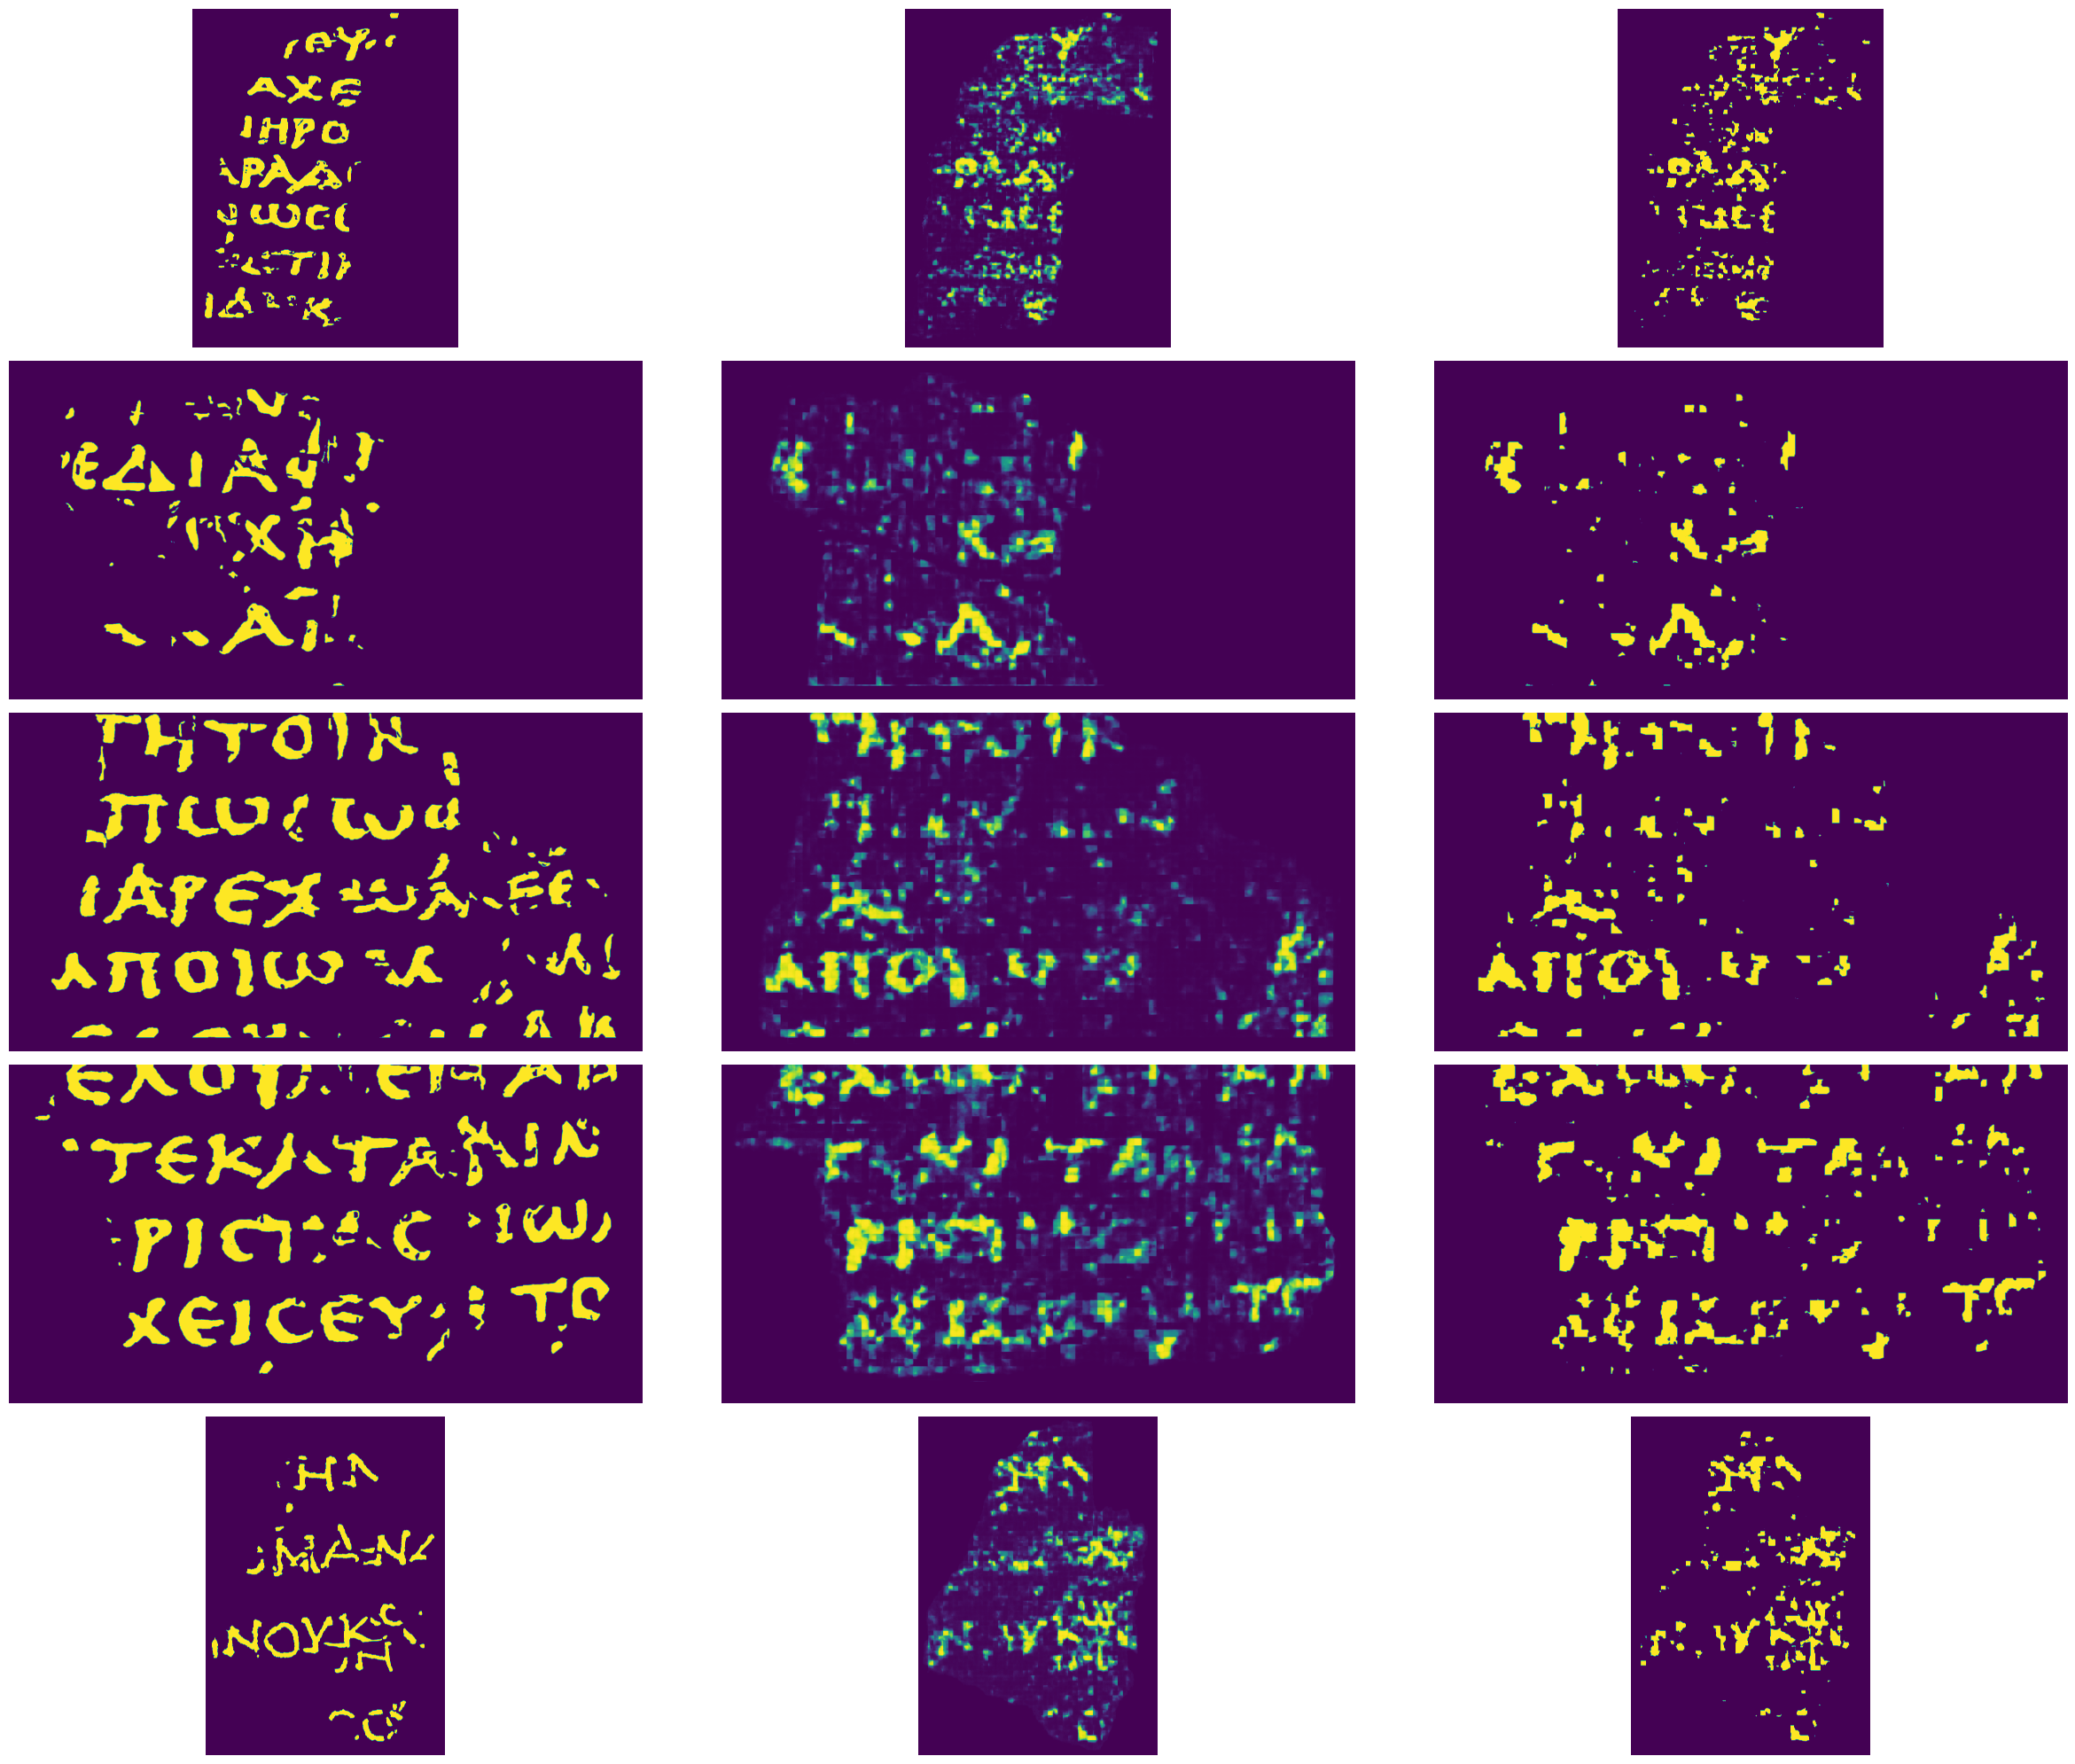

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)